In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt

## Create the toy datasets

In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
def generate_polynomial_dataset(coeffs, width, samples, samples_on_edge):
    def _calculate_value(x_i):
        return np.sum(np.multiply(np.power(np.repeat(x_i, len(coeffs)), range(len(coeffs))), coeffs))
    
    x = np.linspace(-10, 10, 100)
    boundary = [_calculate_value(x_i) for x_i in x]
    margin_1 = [b + width for b in boundary]
    margin_2 = [b - width for b in boundary] 
    
    plt.plot(x, boundary, 'r')
    plt.plot(x, margin_1, 'r', alpha = 0.3)
    plt.plot(x, margin_2, 'r', alpha = 0.3)
    
    # Generate observations on the edge of the margin
    x_1 = []
    while len(x_1) < samples_on_edge:
        value = np.random.uniform(-10, 10)
        x_1.append([value, _calculate_value(value) + width])
    value = np.random.uniform(-10, 10)
    x_2 = [[value, _calculate_value(value) - width]]
    # Generate the rest of the observations
    while len(x_1) < samples or len(x_2) < samples:
        value_x = np.random.uniform(-10, 10)
        value_y = np.random.uniform(min(margin_2), max(margin_1))
        if value_y > _calculate_value(value_x) + width:
            x_1.append([value_x, value_y])
        elif value_y < _calculate_value(value_x) - width:
            x_2.append([value_x, value_y])

    # Output label
    y = np.concatenate((np.repeat(-1, len(x_1)), np.repeat(1, len(x_2))))

    # Final version of the dataset
    x_1.extend(x_2)
    dataset = np.array(x_1)
    dataset = np.concatenate((dataset, y[:, None]), axis = 1)

    _ = plt.plot(dataset[np.where(dataset[:, 2] == -1), 0], 
                 dataset[np.where(dataset[:, 2] == -1), 1], 
                 'o',
                 color = 'tab:blue')
    _ = plt.plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                 dataset[np.where(dataset[:, 2] == 1), 1],
                 'o',
                 color = 'tab:orange')
    
    return dataset

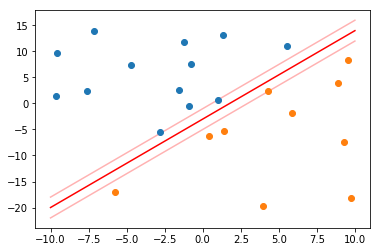

In [4]:
dataset_1 = generate_polynomial_dataset([-3, 1.7], 2, 10, 1)

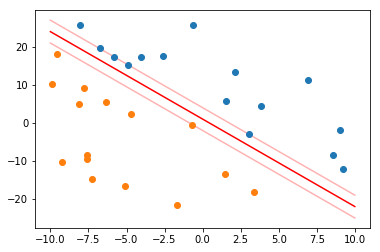

In [5]:
dataset_2 = generate_polynomial_dataset([1, -2.3], 3, 15, 4)

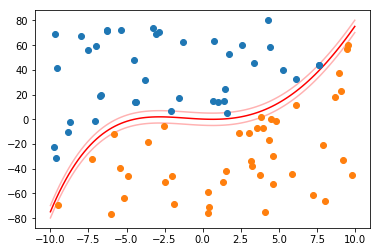

In [6]:
dataset_3 = generate_polynomial_dataset([0.2, -0.5, 0.3, 0.08, -0.003], 5, 40, 4)

In [7]:
def generate_gaussian_dataset(params, width, samples, samples_on_edge):
    # Not really gaussian data, but a toydataset design to be 
    # used with a RBF kernel
    x = np.linspace(-10, 10, 500)
    y = np.linspace(-10, 10, 500)
    xv, yv = np.meshgrid(x, y)
    
    @np.vectorize
    def border(x, y, w):
        close = []
        border = []
        for p in range(len(params)):
            dist = math.sqrt((params[p][0] - x) ** 2 + (params[p][1] - y) ** 2)
            close.append(dist < params[p][2] - w)
            border.append(dist == params[p][2] - w)
        if np.any(border) and np.all(np.logical_not(close)):
            return 0
        elif np.any(close):
            return 1
        else:
            return -1
    
    plt.contour(xv, yv, border(xv, yv, 0), levels = [0], colors = ['r'])
    c = plt.contour(xv, yv, border(xv, yv, width), levels = [0], colors = ['r'], alpha = 0.3)
    plt.contour(xv, yv, border(xv, yv, -width), levels = [0], colors = ['r'], alpha = 0.3)
    
    x_1 = []
    for i in range(len(c.collections[0].get_paths())):
        v = c.collections[0].get_paths()[i].vertices
        indices = list(range(v.shape[0]))
        np.random.shuffle(indices)
        x_1.extend([[v[j, 0], v[j, 1]] for j in indices[:samples_on_edge]])
    x_2 = [] 
    while len(x_1) < samples and len(x_2) < samples:
        value_x = np.random.uniform(-10, 10)
        value_y = np.random.uniform(-10, 10)
        close = False
        margin = False
        for p in range(len(params)):
            dist = math.sqrt((params[p][0] - value_x) ** 2 + (params[p][1] - value_y) ** 2)
            if dist < params[p][2]:
                close = True
            if dist > params[p][2] - width and dist < params[p][2] + width:
                margin = True
        if not margin:
            if close:
                x_1.append([value_x, value_y])
            else:
                x_2.append([value_x, value_y])
            
     # Output label
    y = np.concatenate((np.repeat(-1, len(x_1)), np.repeat(1, len(x_2))))

    # Final version of the dataset
    x_1.extend(x_2)
    dataset = np.array(x_1)
    dataset = np.concatenate((dataset, y[:, None]), axis = 1)

    _ = plt.plot(dataset[np.where(dataset[:, 2] == -1), 0], 
                 dataset[np.where(dataset[:, 2] == -1), 1], 
                 'o',
                 color = 'tab:blue')
    _ = plt.plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                 dataset[np.where(dataset[:, 2] == 1), 1],
                 'o',
                 color = 'tab:orange')
    
    return dataset

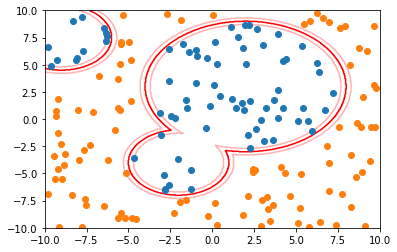

In [8]:
params = [[2, 3, 6],
          [-2, -4, 3],
          [-9, 7.5, 3]]

dataset_4 = generate_gaussian_dataset(params, 0.3, 100, 5)

## Sequential minimal optimisation

This is an implementation of Platt's paper: "Sequential Minimal Optimisation: a fast algorithm for training Support Vector machines".

I am simplifying my implementation by not implementing an error cache. 

In [9]:
class SMO:
    def __init__(self, X, y, C, tol = 0.01, eps = 0.01, kernel = 'linear', kernel_params = None):
        self.X = X
        self.y = y
        self.C = C
        self.tol = tol
        self.eps = eps
        self.kernel = kernel
        self.kernel_params = kernel_params
        
    def _kernel(self, xi, xj):
        if self.kernel == 'linear':
            return np.dot(xi, xj)
        elif self.kernel == 'poly':
            return (self.kernel_params[0] * np.dot(xi, xj) + self.kernel_params[1]) ** self.kernel_params[2]
        elif self.kernel == 'rbf':
            return -self.kernel_params[0] * np.sum(np.power(xi - xj, 2))
        
    def _svm_output(self, x):
        u = 0
        for i in range(self.X.shape[0]):
            u = u + self.y[i] * self.alpha[i] * self._kernel(self.X[i, :], x)
        return u - self.b
        
    def _objective_function(self):
        psi = 0
        for i in range(self.X.shape[0]):
            for j in range(self.X.shape[0]):
                psi = psi + self.y[i] * self.y[j] * self._kernel(self.X[i, :], self.X[j, :]) * self.alpha[i] * self.alpha[j]

        return 0.5 * psi - np.sum(self.alpha)

    def _take_step(self, i1, i2, E2, alph2):
        if i1 == i2:
            return 0

        alph1 = self.alpha[i1]
        y1 = self.y[i1]
        y2 = self.y[i2]
        E1 = self._svm_output(self.X[i1, :]) - y1
        s = y1 * y2

        # compute L, H via equations (13) and (14)
        if y1 != y2:
            L = max(0, alph2 - alph1)
            H = min(self.C, self.C + alph2 - alph1)
        else:
            L = max(0, alph2 + alph1 - self.C)
            H = min(self.C, alph2 + alph1)
        if L == H:
            return 0

        k11 = self._kernel(self.X[i1, :], self.X[i1, :])
        k12 = self._kernel(self.X[i1, :], self.X[i2, :])
        k22 = self._kernel(self.X[i2, :], self.X[i2, :])
        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alph2 + y2 * (E1 - E2) / eta
            if a2 < L:
                a2 = L
            elif a2 > H:
                a2 = H
        else:
            prev_alph2 = alpha[i2]
            self.alpha[i2] = L
            L_obj = self._objective_function()
            self.alpha[i2] = H
            H_obj = self._objective_function()
            self.alpha[i2] = prev_alph2

            if L_obj < H_obj - self.eps:
                a2 = L
            elif L_obj > H_obj + self.eps:
                a2 = H
            else:
                a2 = alph2

        if math.fabs(a2 - alph2) < self.eps * (a2 + alph2 + self.eps):
            return 0

        a1 = alph1 + s * (alph2 - a2)

        # Update threshold to reflect chang in lagrance multipliers
        new_b1 = E1 + y1 * (a1 - self.alpha[i1]) * k11 + y2 * (a2 - self.alpha[i2]) * k12 + self.b
        new_b2 = E2 + y1 * (a1 - self.alpha[i1]) * k12 + y2 * (a2 - self.alpha[i2]) * k22 + self.b

        if a1 < 0 or a1 > self.C:
            self.b = new_b1
        elif a2 < 0 or a2 > self.C:
            self.b = new_b2
        else:
            self.b = (new_b1 + new_b2) / 2.0

        self.alpha[i1] = a1
        self.alpha[i2] = a2

        return 1

    def _examine_example(self, i2):
        y2 = self.y[i2]
        alph2 = self.alpha[i2]
        E2 = self._svm_output(self.X[i2, :]) - y2
        r2 = E2 * y2

        if (r2 < -self.tol and alph2 < self.C) or (r2 > self.tol and alph2 > 0):
            if np.sum(np.logical_and(self.alpha != 0, self.alpha != self.C)) > 1:
                # i1 chosen among the indices that violate the KKT conditions
                i1 = random.randint(0, len(self.alpha) - 1)
                loop = 0
                while loop < len(self.alpha):
                    if not((self.alpha[i1] == 0 and self.y[i1] * self._svm_output(self.X[i1, :]) >= 1) or \
                           (self.alpha[i1] > 0 and self.alpha[i1] < self.C and \
                            self.y[i1] * self._svm_output(self.X[i2, :]) == 1) or \
                           (self.alpha[i1] == self.C and self.y[i1] * self._svm_output(self.X[i1, :]) <= 1)):
                            if self._take_step(i1, i2, E2, alph2):
                                return 1

                    loop = loop + 1
                    i1 = (i1 + 1) % len(self.alpha)

            # Loop over all non-zero and non-C alpha, starting at a randompoint
            indices = np.where(np.logical_and(self.alpha != 0, self.alpha != self.C))[0]
            if len(indices) > 0:
                i = random.randint(0, len(indices) - 1)
                loop = 0
                while loop < len(indices):
                    i1 = indices[i]
                    if self._take_step(i1, i2, E2, alph2):
                        return 1

                    loop = loop + 1
                    i = (i + 1) % len(indices)        

            # Loop over all possible i1, starting at a random point
            i1 = random.randint(0, len(self.alpha) - 1)
            loop = 0
            while loop < len(self.alpha):
                if self._take_step(i1, i2, E2, alph2):
                    return 1

                loop = loop + 1
                i1 = (i1 + 1) % len(self.alpha)

        return 0
        
    def fit(self):
        # Alphas have to be initialised to zero: 
        # https://stats.stackexchange.com/questions/363952/why-do-svms-using-smo-algorithm-work-only-when-the-initial-values-of-the-multipl
        self.alpha = np.zeros(self.X.shape[0], )
        self.b = 0

        num_changed = 0
        examine_all = 1
        while num_changed > 0 or examine_all:
            num_changed = 0
            if examine_all:
                for i in range(self.X.shape[0]):
                    num_changed = num_changed + self._examine_example(i)
            else:
                for i in range(self.X.shape[0]):
                    if self.alpha[i] != 0 and self.alpha[i] != self.C:
                        num_changed = num_changed + self._examine_example(i)
            if examine_all == 1:
                examine_all = 0
            elif num_changed == 0:
                examine_all = 1 
                
    def predict(self, X_test):
        y = []
        for i in range(X_test.shape[0]):
            y.append(int(self._svm_output(X_test[i, :]) > 0))
        return y

In [10]:
def plot_predictions(dataset, smo):
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(16)
    
    # Left side
    _ = ax[0].plot(dataset[np.where(dataset[:, 2] == -1), 0], 
                   dataset[np.where(dataset[:, 2] == -1), 1], 
                   'o',
                   color = 'tab:blue')
    _ = ax[0].plot(dataset[np.where(dataset[:, 2] == 1), 0], 
                   dataset[np.where(dataset[:, 2] == 1), 1],
                   'o',
                   color = 'tab:orange')
    
    # highlight the support vectors
    index = np.where(smo.alpha != 0)[0]
    _ = ax[0].plot(dataset[index, 0], 
                   dataset[index, 1], 
                   'o', 
                   markerSize = 10, 
                   markerfacecolor = 'None',
                   markeredgecolor = 'red',
                   markeredgewidth = 2)
    
    y_lim = ax[0].get_ylim()
    yy = list(np.linspace(y_lim[0], y_lim[1], 100))
    x_lim = ax[0].get_xlim()
    xx = list(np.linspace(x_lim[0], x_lim[1], 100))
    
    colormap = plt.cm.RdYlBu
    res = np.zeros((len(xx), len(yy)))
    for i in range(len(yy)):
        for j in range(len(xx)):
            x_test = np.array([xx[j], yy[i]]).reshape(-1, 1).T
            res[i, j] = smo.predict(x_test)[0]
    ext = [x_lim[0], x_lim[1], y_lim[0], y_lim[1]]
    ax[0].imshow(res, zorder = 0, extent = ext, alpha = 0.5, cmap = colormap, origin = 'lower', aspect = 'auto')
    
    # Right side
    indexes = np.argsort(-smo.alpha)
    ax[1].bar(range(len(smo.alpha)), smo.alpha[indexes])
    ax[1].set_title('alpha values - in descending order')

In [12]:
def test_svm(dataset):
    #smo = SMO(X = dataset[:, :2], y = dataset[:, 2], C = 1)
    #smo = SMO(X = dataset[:, :2], y = dataset[:, 2], C = 1, kernel = 'poly', kernel_params = [1, 0, 3])
    smo = SMO(X = dataset[:, :2], y = dataset[:, 2], C = 1, kernel = 'rbf', kernel_params = [0.5])
    smo.fit()
    
    plot_predictions(dataset, smo)

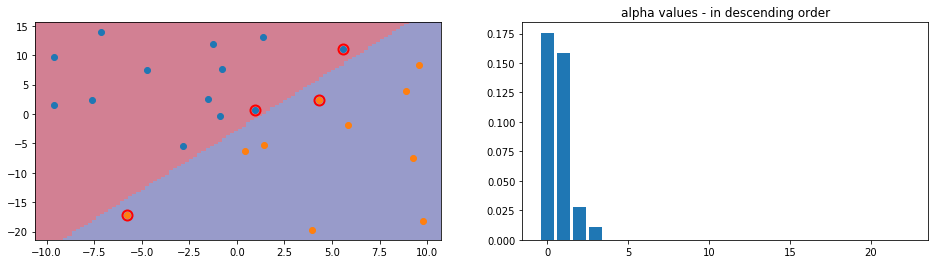

In [12]:
test_svm(dataset_1)

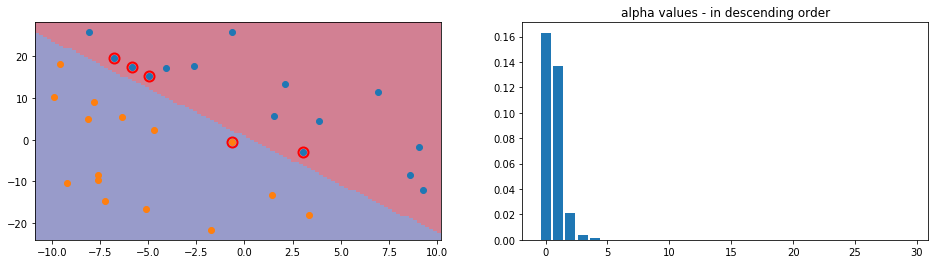

In [13]:
test_svm(dataset_2)

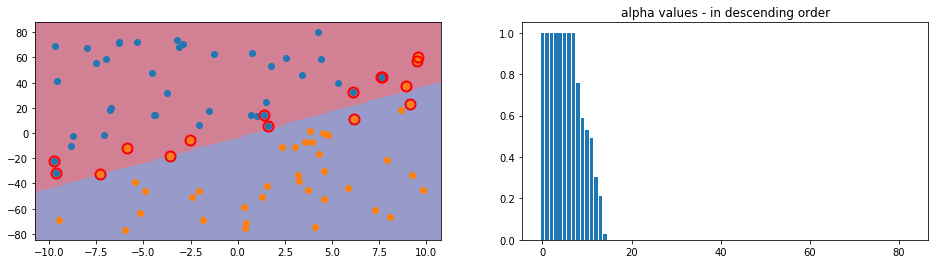

In [14]:
test_svm(dataset_3)

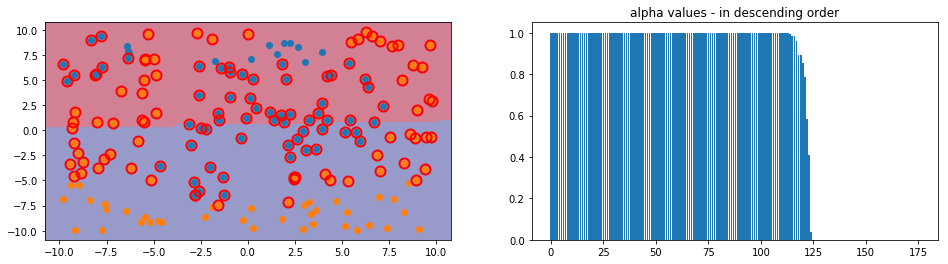

In [13]:
test_svm(dataset_4)

In [16]:

a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
np.sum(np.power(a - b, 2))

27

In [17]:
# TODO: replace all np.dot(a, b) by kernel(a, b)